In [1]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import cv2

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class CatDataset(Dataset):
    
    def __init__(self, images, labels, transform):
        
        self.imgs = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        
        return len(self.imgs) # return DataSet 長度
 
    def __getitem__(self, idx):

        image = self.imgs[idx]
        image = image[...,::-1].copy()
        image = self.transform(image)
        label = np.array(self.labels[idx])
            
        return image, label # return 模型訓練所需的資訊


In [5]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    #transforms.Resize(224),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
 
test_transformer = transforms.Compose([
    #transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# datas is a list with a lot of data [cat_00,cat_01,...]
def split_Train_Val_Data(datas):
    
    data = []
    for d in datas:
        imgs = d.item().get('imgs')
        lmks = d.item().get('bbs')
        for i in range(len(imgs)):
            data.append([imgs[i],lmks[i]])
    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []

    num_sample_train = int(len(data)*0.9)
    num_sample_test = len(data)-num_sample_train

    print(str(len(data)) + ' | ' + str(num_sample_train) + ' | ' + str(num_sample_test))

    for x in data[0:num_sample_train] : # 前 80% 資料存進 training list
        train_inputs.append(x[0])
        train_labels.append(x[1])

    for x in data[num_sample_train:len(data)] : # 後 20% 資料存進 testing list
        test_inputs.append(x[0])
        test_labels.append(x[1])
            
#     for i in range(5):
#         print(train_inputs[i],train_labels[i])
    train_dataloader = DataLoader(CatDataset(train_inputs,train_labels,train_transformer),
                                  batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(CatDataset(test_inputs,test_labels,test_transformer),
                                  batch_size = batch_size, shuffle = False)
 
    return train_dataloader, test_dataloader

In [6]:
class PytorchModule(nn.Module):

    def __init__(self):
        super(PytorchModule,self).__init__()
        v = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
        v.classifier[1] = nn.Linear(v.last_channel, 4)
#         v = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d',pretrained=False)
#         v.fc = nn.Linear(2048, 4)
        self.layer1 = v
               
    def forward(self, x):
        out = self.layer1(x)
        return out

In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,predice,label):
        return torch.sqrt(self.mse(predice,label))

In [8]:
def distence(x1,y1,x2,y2):
    return (x1-x2)**2 + (y1-y2)**2

In [9]:
batch_size = 64
lr = 1e-3
epochs = 500


In [10]:
datas = []
dataset_name =["../dataset/CAT_00.npy","../dataset/CAT_01.npy","../dataset/CAT_02.npy",
               "../dataset/CAT_03.npy","../dataset/CAT_04.npy","../dataset/CAT_05.npy"]
for name in dataset_name:
    data = np.load(name,allow_pickle=True)
    datas.append(data)
train_dataloader, test_dataloader = split_Train_Val_Data(datas)

C = PytorchModule().to(device) 
optimizer_C = optim.Adam(C.parameters(), lr = lr) 
#print(C)
summary(C, (3, 224, 224)) 

# Loss function
criterion = RMSELoss()

8609 | 7748 | 861


Using cache found in C:\Users\kaoti/.cache\torch\hub\pytorch_vision_v0.6.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [11]:
loss_epoch_C = []
train_acc, test_acc = [[],[]], [[],[]]
train_delta, test_delta = [], []
best_acc, best_auc = 0.0, 0.0
corrects = []

In [12]:
%%time

radius2 = 25
store_name = "mobilenet_RMSELoss500"

if __name__ == '__main__':    
    
    for epoch in range(epochs):
    
        iter = 0
        total_train = 0
        total_test = 0
        correct_top_test, correct_down_test = 0, 0
        correct_top_train, correct_down_train = 0, 0
        train_loss_C = 0.0

        C.train() 
      
        print('epoch:%4d' %(epoch + 1) + ' / ' + str(epochs) ,end = " ")  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
            
            optimizer_C.zero_grad() 
            
            output = C(x) 
            #print(output,label.long())
            loss = criterion(output,label.float())
            
            loss.backward() 
            optimizer_C.step() 
            
            predicted = output.data
            total_train += len(label)
            # if the distence of the left predicted point to the real point is samller than 5, correct++
            for i in range(len(predicted)):
                if(distence(predicted[i][0],predicted[i][1],label[i][0],label[i][1]) < radius2):
                    correct_top_train += 1
                if(distence(predicted[i][2],predicted[i][3],label[i][2],label[i][3]) < radius2):
                    correct_down_train += 1
            train_loss_C += loss.item()
            iter += 1
                    
        print('Training epoch:%4d / loss_C: %4.3f | acc_top: %.3f | acc_down %.3f |' % \
              (epoch + 1, train_loss_C / iter, correct_top_train / total_train, correct_down_train/total_train ) ,end = " ")

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() 
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            with torch.no_grad():
                x, label = x.to(device), label.to(device)
                
                output = C(x) 
                loss = criterion(output, label.long())
                predicted = output.data
                total_test += len(label)
                for i in range(len(predicted)):
                    if(distence(predicted[i][0],predicted[i][1],label[i][0],label[i][1]) < radius2):
                        correct_top_test += 1
                    if(distence(predicted[i][2],predicted[i][3],label[i][2],label[i][3]) < radius2):
                        correct_down_test += 1
                #correct_test += (predicted == label).int().sum()
        
        print('Testing acc: top %.3f , down %.3f' % (correct_top_test / total_test, correct_down_test / total_test))
                                     
        train_acc[0].append(100 * (correct_top_train / total_train)) # training accuracy
        train_acc[1].append(100 * (correct_down_train / total_train))
        test_acc[0].append(100 * (correct_top_test / total_test))  # testing accuracy
        test_acc[1].append(100 * (correct_down_test / total_test))
        loss_epoch_C.append(loss.data) # loss 
        
    #save the model variable to .ph file
    torch.save(C.state_dict(), store_name + ".ph")
    

epoch:   1 / 500 Training epoch:   1 / loss_C: 61.784 | acc_top: 0.015 | acc_down 0.001 | Testing acc: top 0.041 , down 0.050
epoch:   2 / 500 Training epoch:   2 / loss_C: 14.863 | acc_top: 0.124 | acc_down 0.102 | Testing acc: top 0.158 , down 0.166
epoch:   3 / 500 Training epoch:   3 / loss_C: 9.737 | acc_top: 0.197 | acc_down 0.199 | Testing acc: top 0.305 , down 0.204
epoch:   4 / 500 Training epoch:   4 / loss_C: 8.195 | acc_top: 0.244 | acc_down 0.242 | Testing acc: top 0.393 , down 0.402
epoch:   5 / 500 Training epoch:   5 / loss_C: 7.046 | acc_top: 0.297 | acc_down 0.297 | Testing acc: top 0.438 , down 0.382
epoch:   6 / 500 Training epoch:   6 / loss_C: 6.801 | acc_top: 0.309 | acc_down 0.325 | Testing acc: top 0.180 , down 0.308
epoch:   7 / 500 Training epoch:   7 / loss_C: 7.539 | acc_top: 0.266 | acc_down 0.266 | Testing acc: top 0.199 , down 0.145
epoch:   8 / 500 Training epoch:   8 / loss_C: 7.070 | acc_top: 0.304 | acc_down 0.298 | Testing acc: top 0.355 , down 0.50

epoch: 131 / 500 Training epoch: 131 / loss_C: 2.939 | acc_top: 0.853 | acc_down 0.737 | Testing acc: top 0.806 , down 0.761
epoch: 132 / 500 Training epoch: 132 / loss_C: 2.883 | acc_top: 0.851 | acc_down 0.752 | Testing acc: top 0.758 , down 0.582
epoch: 133 / 500 Training epoch: 133 / loss_C: 2.813 | acc_top: 0.863 | acc_down 0.753 | Testing acc: top 0.815 , down 0.803
epoch: 134 / 500 Training epoch: 134 / loss_C: 2.707 | acc_top: 0.884 | acc_down 0.777 | Testing acc: top 0.780 , down 0.822
epoch: 135 / 500 Training epoch: 135 / loss_C: 2.677 | acc_top: 0.880 | acc_down 0.794 | Testing acc: top 0.826 , down 0.837
epoch: 136 / 500 Training epoch: 136 / loss_C: 2.696 | acc_top: 0.894 | acc_down 0.780 | Testing acc: top 0.822 , down 0.790
epoch: 137 / 500 Training epoch: 137 / loss_C: 2.670 | acc_top: 0.897 | acc_down 0.790 | Testing acc: top 0.801 , down 0.821
epoch: 138 / 500 Training epoch: 138 / loss_C: 2.786 | acc_top: 0.861 | acc_down 0.776 | Testing acc: top 0.811 , down 0.798


epoch: 261 / 500 Training epoch: 261 / loss_C: 2.439 | acc_top: 0.928 | acc_down 0.829 | Testing acc: top 0.840 , down 0.718
epoch: 262 / 500 Training epoch: 262 / loss_C: 2.475 | acc_top: 0.917 | acc_down 0.822 | Testing acc: top 0.840 , down 0.818
epoch: 263 / 500 Training epoch: 263 / loss_C: 2.504 | acc_top: 0.919 | acc_down 0.818 | Testing acc: top 0.849 , down 0.836
epoch: 264 / 500 Training epoch: 264 / loss_C: 2.469 | acc_top: 0.923 | acc_down 0.819 | Testing acc: top 0.820 , down 0.806
epoch: 265 / 500 Training epoch: 265 / loss_C: 2.456 | acc_top: 0.928 | acc_down 0.820 | Testing acc: top 0.841 , down 0.842
epoch: 266 / 500 Training epoch: 266 / loss_C: 2.416 | acc_top: 0.930 | acc_down 0.828 | Testing acc: top 0.836 , down 0.844
epoch: 267 / 500 Training epoch: 267 / loss_C: 2.456 | acc_top: 0.925 | acc_down 0.826 | Testing acc: top 0.846 , down 0.848
epoch: 268 / 500 Training epoch: 268 / loss_C: 2.487 | acc_top: 0.927 | acc_down 0.814 | Testing acc: top 0.851 , down 0.843


epoch: 391 / 500 Training epoch: 391 / loss_C: 2.399 | acc_top: 0.934 | acc_down 0.831 | Testing acc: top 0.829 , down 0.822
epoch: 392 / 500 Training epoch: 392 / loss_C: 2.371 | acc_top: 0.939 | acc_down 0.832 | Testing acc: top 0.841 , down 0.841
epoch: 393 / 500 Training epoch: 393 / loss_C: 2.386 | acc_top: 0.937 | acc_down 0.834 | Testing acc: top 0.843 , down 0.857
epoch: 394 / 500 Training epoch: 394 / loss_C: 2.339 | acc_top: 0.946 | acc_down 0.839 | Testing acc: top 0.850 , down 0.836
epoch: 395 / 500 Training epoch: 395 / loss_C: 2.366 | acc_top: 0.943 | acc_down 0.829 | Testing acc: top 0.849 , down 0.859
epoch: 396 / 500 Training epoch: 396 / loss_C: 2.374 | acc_top: 0.939 | acc_down 0.826 | Testing acc: top 0.828 , down 0.859
epoch: 397 / 500 Training epoch: 397 / loss_C: 2.383 | acc_top: 0.938 | acc_down 0.828 | Testing acc: top 0.834 , down 0.852
epoch: 398 / 500 Training epoch: 398 / loss_C: 2.397 | acc_top: 0.935 | acc_down 0.834 | Testing acc: top 0.839 , down 0.861


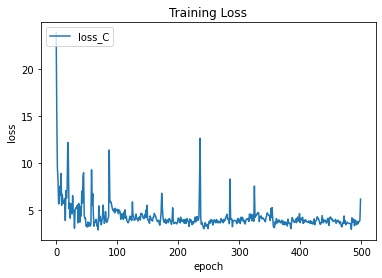

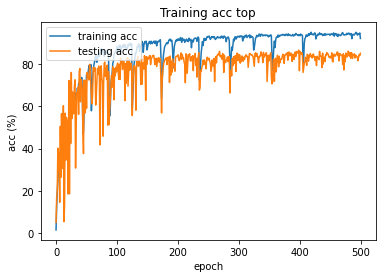

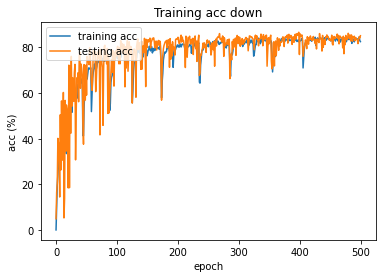

In [13]:
plt.figure()

x=loss_epoch_C # plot your loss
plt.plot(x)
plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
#plt.savefig("resnext50-pretrained-loss.png")
plt.show()

plt.figure()

x1 = train_acc[0] # plot your training accuracy
x2 = test_acc[1] # plot your testing accuracy
plt.plot(x1)
plt.plot(x2)
plt.title('Training acc top')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.savefig(store_name + "acc_top.png")
plt.show()

plt.figure()
x1 = train_acc[1] # plot your training accuracy
x2 = test_acc[1] # plot your testing accuracy
plt.plot(x1)
plt.plot(x2)
plt.title('Training acc down')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.savefig(store_name+"acc_down.png")
plt.show()

In [6]:
img_size = 224
def resize_img(im):
    old_size = im.shape[:2]  # old_size is in (height, width) format
    ratio = float(img_size) / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                value=[0, 0, 0])
    return new_im, ratio, top, left

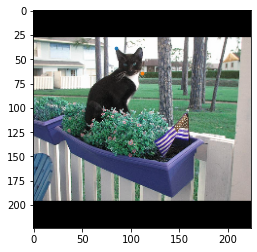

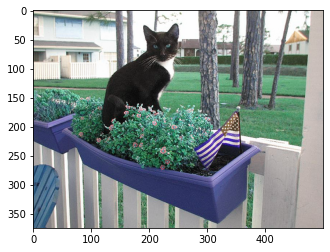

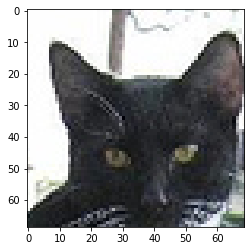

In [7]:
#test and print the result

data = np.load("../dataset/CAT_06.npy",allow_pickle=True)
imgs = data.item().get("imgs")
bbs = data.item().get("bbs")
filenames = data.item().get("filenames")
path = "../cats/CAT_06/"
i=1
#plot the box point on the resized picture
plt.figure()
plt.scatter(x = bbs[i][0],y = bbs[i][1],s = 7)
plt.scatter(x = bbs[i][2],y = bbs[i][3],s = 7)
plt.imshow(imgs[i])

#plot the origin picture
img = cv2.imread(path + filenames[i])
plt.figure()
plt.imshow(img)


ori_img = img.copy()

img, ratio, top, left = resize_img(img)

#now i use the valid point first
pred_bb = bbs[i].reshape(-1,2)

#move and cut the image
ori_bb = ((pred_bb - np.array([left, top])) / ratio).astype(np.int)
center = np.mean(ori_bb, axis=0)
face_size = max(np.abs(ori_bb[1] - ori_bb[0]))
new_bb = np.array([
  center - face_size * 0.6,
  center + face_size * 0.6
]).astype(np.int)
new_bb = np.clip(new_bb, 0, 99999)
#cut the image
face_img = ori_img[new_bb[0][1]:new_bb[1][1], new_bb[0][0]:new_bb[1][0]]

#change the picture color from bgr to rgb
face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

#plot the cat face
plt.figure()
plt.imshow(face_img)

### test the model

In [14]:

#load the model
model = PytorchModule().to(device)
model.load_state_dict(torch.load("mobilenet_RMSELoss500.ph"))
model.eval()

#Load the data
data = np.load("dataset/CAT_06.npy",allow_pickle=True)
images = data.item().get("imgs")
imgs = []
for image in images:
    #plt.imshow(image)
    image = image[...,::-1].copy()
    imgs.append(image)
    #plt.imshow(image)

Using cache found in C:\Users\kaoti/.cache\torch\hub\pytorch_vision_v0.6.0


In [15]:
# test the data, because the model need input data number same as batch_size,
# so we will test batch_size's number of picture in a iteration.

# get the dataloader for cat06 test, the cat06 is not in any train or test data
def outside_test():
    data = np.load("dataset/CAT_06.npy",allow_pickle=True)
    imgs = data.item().get("imgs")
    bbs = data.item().get("bbs")
    
    test_inputs = imgs
    test_labels = bbs
            
    test_dataloader = DataLoader(CatDataset(test_inputs,test_labels,test_transformer),
                                 batch_size = 32, shuffle = False)
    return test_dataloader
test_dataloader = outside_test()


correct_6_top = 0 
correct_6_down = 0
total_6 = 0
for i, (x, label) in enumerate(test_dataloader) :
        with torch.no_grad(): # 測試階段不需要求梯度
            x, label = x.to(device), label.to(device)
            output = model(x) # 將測試資料輸入至模型進行測試
            loss = criterion(output, label.long()) # 計算測試資料的準確度
            #predicted = torch.max(output.data, 1)[1]
            predicted = output.data
            total_6 += len(label)
            for j in range(len(predicted)):
                if(distence(predicted[j][0],predicted[j][1],label[j][0],label[j][1]) < 25):
                    correct_6_top += 1
                if(distence(predicted[j][2],predicted[j][3],label[j][2],label[j][3]) < 25):
                    correct_6_down += 1
                    
                    
#                 plt.figure()
#                 for k in range(0,4,2):
#                     plt.scatter(x = label.cpu()[j][k], y = label.cpu()[j][k+1], s = 7, color = "#40FF1E")
#                     #predicted position, orange point
#                     plt.scatter(x = predicted.cpu()[j][k], y = predicted.cpu()[j][k+1], s = 7, color = "#FF6C1E")
#                 plt.title("%d"%(i+j))
#                 plt.imshow(imgs[i+j])
#         break

print('Testing acc: top %.3f, down %.3f ' % (correct_6_top / total_6 , correct_6_down / total_6))

Testing acc: top 0.827, down 0.845 


### the accuracy of the picture, the dataset is from Cat_06
    if the predict point is 5 pixel near with the correct point then it counts
    
|name| loss function| epoch | top acc | down acc|
|-----|----|-------------|-------|------|
|mobilenet_RMSELoss | RMSE | 100 |    0.803 | 0.831| 
|cat_face_mobilenetv2_300 | MSE |300 |  0.813 | 0.814 |
|cat_face_mobilenetv2 | MSE | ??? | 0.723| 0.726 |
|mobilenet_RMSELoss500| RMSE | 500 | 0.827 | 0.845|